In [3]:
#Library Imports
import pandas as pd
import numpy as np
import os
from scipy.optimize import minimize

#Utility Function Imports
from utilities import *

#Algorithm Imports
from Strategies.benchmarks import *
from Strategies.follow_the_loser import *
from Strategies.follow_the_winner import *
from Strategies.pattern_matching import *
from Strategies.meta_learning import *

pd.set_option('future.no_silent_downcasting', True)

In [4]:
##############################################################################
# ALGORITHMS / STRATEGIES
##############################################################################

# Strategy 1: Buy and Hold
def buy_and_hold(b, price_relative_vectors):
    """
    Buy-and-hold: invests initial weights 'b' in each asset and never rebalances.
    The returned b_n is purely for reference; the actual wealth grows un-rebalanced.
    """
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b

    for t in range(1, T):
        # The nominal holdings scale by price_relative_vectors[t-1].
        # Then (optionally) we can track the fraction of total. But by definition,
        # buy-and-hold doesn't rebalance, so the fraction can be seen as
        # (old holdings * x_{t-1}) / sum(...).
        new_portfolio = b_n[t-1] * price_relative_vectors[t-1]
        new_portfolio /= np.sum(new_portfolio)
        b_n[t] = new_portfolio

    return b_n

# Strategy 2: Best Stock
def best_stock(b, price_relative_vectors):
    """
    At each period, invests entirely in whichever stock performed best in the previous period.
    """
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    # Start with uniform
    b_n[0] = b

    for t in range(1, T):
        best_idx = np.argmax(price_relative_vectors[t-1])
        new_portfolio = np.zeros(N)
        new_portfolio[best_idx] = 1.0
        b_n[t] = new_portfolio

    return b_n

# Strategy 3: Constant Rebalancing
def constant_rebalancing(b, price_relative_vectors):
    """
    Always hold the same proportion 'b' each period (rebalance to b each time).
    """
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    for t in range(T):
        b_n[t] = b
    return b_n

# Strategy 4: Universal Portfolios (Approximation)
def universal_portfolios(b, price_relative_vectors, num_portfolios=500):
    """
    Cover's Universal Portfolios, approximated by sampling 'num_portfolios' random points
    on the simplex. We track the wealth of each sampled portfolio over time and then 
    blend them by their (normalized) wealth to form a final "universal" portfolio each step.
    """
    T, N = price_relative_vectors.shape
    # Sample many random portfolios on the simplex
    portfolios = np.random.dirichlet(np.ones(N), size=num_portfolios)  # shape (num_portfolios, N)
    
    # Each portfolio has a wealth, starting at 1.0
    wealth = np.ones(num_portfolios)
    
    # The universal mixture portfolio at each time step
    b_n = np.zeros((T, N))
    
    for t in range(T):
        # Weighted average of the sampled portfolios (weights = their current wealth)
        w_t = np.average(portfolios, axis=0, weights=wealth)
        # Project or re-normalize to ensure sum to 1 (should already be near 1).
        w_t /= w_t.sum()
        b_n[t] = w_t

        # Next, we observe the price relative x_t and update each portfolio's wealth
        x_t = price_relative_vectors[t]
        # The return for each sampled portfolio is dot(portfolio, x_t)
        portfolio_returns = portfolios.dot(x_t)
        wealth *= portfolio_returns

    return b_n

# Strategy 5: Exponential Gradient
def exponential_gradient(b, price_relative_vectors, learning_rate=0.1):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b

    for t in range(1, T):
        x_t = price_relative_vectors[t-1]  # The return from previous step
        portfolio_return = np.dot(b_n[t-1], x_t)

        # Helmbold's exponential update
        new_b = b_n[t-1].copy()
        for i in range(N):
            new_b[i] *= (learning_rate * (x_t[i]/(portfolio_return+1e-15) - 1) + 1)

        new_b = new_b / np.sum(new_b)
        b_n[t] = new_b
    
    return b_n

# Strategy 6: Follow-The-Leader
def follow_the_leader(b, price_relative_vectors, gamma=0.5):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b

    for t in range(1, T):
        # Up to time t-1
        cumulative_log_returns = np.sum(np.log(price_relative_vectors[:t]), axis=0)
        b_star = np.exp(cumulative_log_returns)
        b_star /= np.sum(b_star)

        b_n[t] = (1 - gamma) * b_star + gamma * b_n[t-1]
        b_n[t] /= np.sum(b_n[t])
    return b_n

# Helper for FTRL-based methods
def project_to_simplex(v):
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - 1
    rho = np.nonzero(u > cssv / np.arange(1, n+1))[0][-1]
    theta = cssv[rho] / (rho + 1.0)
    return np.maximum(v - theta, 0)

# Strategy 7: Follow the Regularized Leader (simplified ONS style)
def follow_the_regularized_leader(b, price_relative_vectors, beta=0.1, delta=0.5):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b.copy()
    A_t = np.eye(N)

    for t in range(1, T):
        # price relatives at time t-1
        x_t = price_relative_vectors[t-1]
        port_return = np.dot(b_n[t-1], x_t)

        A_t += np.outer(x_t, x_t)/(port_return+1e-15)**2 + np.eye(N)*1e-3  # small ridge

        # Summation-like term p_t
        # For a purely incremental approach, we'd store partial sums. Here is a naive approach:
        # sum over tau in [0..t-1]
        grad_sum = np.zeros(N)
        for tau in range(t):
            x_tau = price_relative_vectors[tau]
            b_tau = b_n[tau]
            grad_sum += x_tau / (np.dot(b_tau, x_tau) + 1e-15)
        p_t = (1 + (1 / beta)) * grad_sum

        new_b = np.linalg.inv(A_t).dot(p_t) * delta
        new_b = project_to_simplex(new_b)
        b_n[t] = new_b

    return b_n

# Strategy 8: Aggregation-Based (Simple)
def aggregation_based_simple(b, price_relative_vectors, learning_rate=0.5):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b

    base_portfolios = np.random.dirichlet(np.ones(N), N)
    prior_weights = np.ones(N) / N

    for t in range(T):
        # Compute performance of each base portfolio up to time t
        if t == 0:
            portfolio_performance = np.ones(N)
        else:
            # product of returns up to time t-1
            # shape: base_portfolios is (N, N?), might need to do an iterative approach
            portfolio_performance = np.ones(len(base_portfolios))
            for i in range(t):
                x_i = price_relative_vectors[i]
                # each row in base_portfolios is a portfolio
                portfolio_performance *= base_portfolios.dot(x_i)

        adjusted_weights = prior_weights * (portfolio_performance ** learning_rate)
        adjusted_weights /= np.sum(adjusted_weights)

        b_n[t] = adjusted_weights.dot(base_portfolios)

    return b_n

# Strategy 9: Anti-Correlation (Anticor) - Simplified
def anticor(b, price_relative_vectors, window_size=5):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b

    for t in range(1, T):
        if t >= 2 * window_size:
            y1 = np.log(price_relative_vectors[t - 2*window_size : t - window_size])
            y2 = np.log(price_relative_vectors[t - window_size : t])

            if y1.shape[0] > 0 and y2.shape[0] > 0:
                mean_y1 = np.mean(y1, axis=0)
                mean_y2 = np.mean(y2, axis=0)

                Mcov = np.cov(y1.T, y2.T)[:N, N:]
                std_y1 = np.std(y1, axis=0)
                std_y2 = np.std(y2, axis=0)
                std_y1[std_y1 == 0] = 1e-10
                std_y2[std_y2 == 0] = 1e-10
                Mcor = Mcov / np.outer(std_y1, std_y2)

                transfer_amounts = np.zeros(N)
                for i in range(N):
                    for j in range(N):
                        if Mcor[i, j] > 0:
                            transfer_amount = Mcor[i, j]
                            transfer_amounts[i] -= transfer_amount
                            transfer_amounts[j] += transfer_amount

                b_star = b_n[t-1] + transfer_amounts
                b_star = np.maximum(b_star, 0)
                if np.sum(b_star) > 0:
                    b_star /= np.sum(b_star)
                b_n[t] = b_star
            else:
                b_n[t] = b_n[t-1]
        else:
            b_n[t] = b_n[t-1]

    return b_n

# Strategy 10: PAMR
def pamr(b, price_relative_vectors, epsilon=0.5):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b

    for t in range(1, T):
        x_t = price_relative_vectors[t-1]
        portfolio_return = np.dot(b_n[t-1], x_t)

        x_t_mean = np.mean(x_t)
        x_t_diff = x_t - x_t_mean
        denom = np.linalg.norm(x_t_diff)**2
        if denom > 0:
            tau_t = max(0, (portfolio_return - epsilon) / denom)
        else:
            tau_t = 0

        b_t1 = b_n[t-1] - tau_t * x_t_diff
        b_t1 = np.maximum(b_t1, 0)
        if np.sum(b_t1) > 0:
            b_t1 /= np.sum(b_t1)
        b_n[t] = b_t1

    return b_n

# Strategy 11: CWMR (simplified)
def cwmr(b, price_relative_vectors, epsilon=0.5, theta=0.95):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b.copy()

    mu_t = b.copy().astype(np.float64)
    Sigma_t = np.eye(N)*1.0

    for t in range(1, T):
        x_t = price_relative_vectors[t-1]
        x_t_mean = np.dot(mu_t, x_t)

        # x_t_tilde not strictly needed in this simplified version.
        # We'll keep it minimal.
        denominator = x_t @ (Sigma_t @ x_t)
        if denominator <= 0:
            lambda_t = 0
        else:
            lambda_t = max(0, (x_t_mean - epsilon)/denominator)

        mu_t -= lambda_t * Sigma_t @ x_t
        # Update Sigma
        Sigma_t_inv = np.linalg.inv(Sigma_t + np.eye(N)*1e-12)
        Sigma_t_inv += 2 * lambda_t * theta * np.outer(x_t, x_t)
        Sigma_t = np.linalg.inv(Sigma_t_inv)

        mu_t = project_to_simplex(mu_t)
        b_n[t] = mu_t

    return b_n

# Strategy 12: OLMAR
def olmar(b, price_relative_vectors, window_size=10, epsilon=0.5):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b

    for t in range(1, T):
        # Weighted moving average
        if t < window_size:
            ma_t = np.mean(price_relative_vectors[:t], axis=0)
        else:
            ma_t = np.mean(price_relative_vectors[t-window_size : t], axis=0)

        # Basic prediction x_t_tilde
        # Just a placeholder. The real OLMAR logic is more nuanced.
        x_t_tilde = ma_t  # very simplified

        b_t = b_n[t-1]
        x_t_tilde_mean = np.dot(b_t, x_t_tilde)
        if x_t_tilde_mean < epsilon:
            tau = (epsilon - x_t_tilde_mean)/ (np.dot(x_t_tilde, x_t_tilde)+1e-15)
            b_t1 = b_t + tau*(x_t_tilde - b_t)
            b_t1 = project_to_simplex(b_t1)
        else:
            b_t1 = b_t
        b_n[t] = b_t1

    return b_n

# Strategy 13: RMR
def calculate_l1_median(data):
    def objective_function(mu):
        return np.sum(np.linalg.norm(data - mu, axis=1))
    initial_guess = np.mean(data, axis=0)
    result = minimize(objective_function, initial_guess)
    return result.x

def rmr(b, price_relative_vectors, window_size=10, epsilon=0.8):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b.copy()

    for t in range(1, T):
        if t < window_size:
            window_data = price_relative_vectors[:t]
        else:
            window_data = price_relative_vectors[t-window_size : t]

        mu_t_plus_1 = calculate_l1_median(np.array(window_data, dtype=np.float64))
        # Predict next
        x_t_tilde = mu_t_plus_1 / (price_relative_vectors[t-1]+1e-15)

        b_t = b_n[t-1]
        x_t_tilde_mean = np.dot(b_t, x_t_tilde)
        if x_t_tilde_mean < epsilon:
            tau = (epsilon - x_t_tilde_mean)/ (np.dot(x_t_tilde, x_t_tilde)+1e-15)
            b_t1 = b_t + tau*(x_t_tilde - b_t)
            b_t1 = project_to_simplex(b_t1)
        else:
            b_t1 = b_t
        b_n[t] = b_t1

    return b_n

##############################################################################
# PATTERN-MATCHING FRAMEWORK
##############################################################################

def histogram_based_selection(price_relative_vectors, w=5, bins=[(0,0.5),(0.5,1),(1,1.5)]):
    n = len(price_relative_vectors)
    if n < w:
        return []
    rolling_means = np.array([np.mean(price_relative_vectors[i-w:i], axis=0) for i in range(w,n+1)])
    latest_mean = np.mean(rolling_means[-1])
    latest_bin = next((idx for idx,(low,high) in enumerate(bins) if low <= latest_mean < high), -1)

    C = []
    for i in range(len(rolling_means)-1):
        hist_mean = np.mean(rolling_means[i])
        hist_bin = next((idx for idx,(low,high) in enumerate(bins) if low <= hist_mean < high), -1)
        if hist_bin == latest_bin:
            C.append(i + w)
    return C

def kernel_based_selection(price_relative_vectors, w=5, threshold=0.2):
    n = len(price_relative_vectors)
    if n < w:
        return []
    C = []
    latest_window = np.mean(price_relative_vectors[-w:], axis=0)

    for i in range(w, n):
        historical_window = np.mean(price_relative_vectors[i-w:i], axis=0)
        distance = np.linalg.norm(latest_window - historical_window)
        if distance <= threshold / np.sqrt(w):
            C.append(i)
    return C

def nearest_neighbor_selection(price_relative_vectors, w=5, num_neighbors=3):
    n = len(price_relative_vectors)
    if n < w:
        return []
    latest_window = np.mean(price_relative_vectors[-w:], axis=0)
    distances = []
    for i in range(w, n):
        historical_window = np.mean(price_relative_vectors[i-w:i], axis=0)
        dist = np.linalg.norm(latest_window - historical_window)
        distances.append((i, dist))
    distances.sort(key=lambda x: x[1])
    C = [idx for idx,_ in distances[:num_neighbors]]
    return C

def correlation_based_selection(price_relative_vectors, w=5, rho=0.7):
    n = len(price_relative_vectors)
    if n < w:
        return []
    C = []
    latest_window = np.mean(price_relative_vectors[-w:], axis=0)
    for i in range(w,n):
        historical_window = np.mean(price_relative_vectors[i-w:i], axis=0)
        corr = np.corrcoef(latest_window, historical_window)[0,1]
        if corr >= rho:
            C.append(i)
    return C

def log_optimal_portfolio(C, price_relative_vectors):
    if not C:
        m = price_relative_vectors.shape[1]
        return np.ones(m)/m
    X_C = price_relative_vectors[C]

    def objective(b):
        return -np.sum(np.log(np.dot(X_C,b)+1e-15))/len(C)

    cons = ({'type':'eq','fun':lambda b: np.sum(b)-1})
    bounds = [(0,1)]*price_relative_vectors.shape[1]
    b_init = np.ones(price_relative_vectors.shape[1])/price_relative_vectors.shape[1]
    result = minimize(objective, b_init, method='SLSQP', bounds=bounds, constraints=cons)
    return result.x

def semi_log_optimal_portfolio(C, price_relative_vectors):
    if not C:
        m = price_relative_vectors.shape[1]
        return np.ones(m)/m
    X_C = price_relative_vectors[C]

    def f_z(z):
        return z - 0.5*(z-1)**2

    def objective(b):
        return -np.sum(f_z(np.dot(X_C,b)))/len(C)

    cons = ({'type':'eq','fun':lambda b: np.sum(b)-1})
    bounds = [(0,1)] * price_relative_vectors.shape[1]
    b_init = np.ones(price_relative_vectors.shape[1])/price_relative_vectors.shape[1]
    result = minimize(objective, b_init, method='SLSQP', bounds=bounds, constraints=cons)
    return result.x

def markowitz_portfolio(C, price_relative_vectors, lambda_=0.5):
    if not C:
        m = price_relative_vectors.shape[1]
        return np.ones(m)/m
    X_C = price_relative_vectors[C]
    mean_returns = np.mean(X_C, axis=0)
    cov_matrix = np.cov(X_C, rowvar=False)

    def objective(b):
        return -np.dot(b, mean_returns) + lambda_* b.T.dot(cov_matrix).dot(b)

    cons = ({'type':'eq','fun':lambda b: np.sum(b)-1})
    bounds = [(0,1)] * price_relative_vectors.shape[1]
    b_init = np.ones(price_relative_vectors.shape[1])/price_relative_vectors.shape[1]
    result = minimize(objective, b_init, method='SLSQP', bounds=bounds, constraints=cons)
    return result.x

def pattern_matching_portfolio_master(b, price_relative_vectors, methods, w=5):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b

    for t in range(1, T):
        if t >= w:
            C_t = methods['sample_selection'](price_relative_vectors[:t], w=w)
        else:
            C_t = []
        b_t = methods['portfolio_optimization'](C_t, price_relative_vectors[:t])
        b_n[t] = b_t
    return b_n

##############################################################################
# META-LEARNING ALGORITHMS
##############################################################################

def aggregation_algorithm_generalized(b, price_relative_vectors, learning_rate=0.5):
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))
    b_n[0] = b
    expert_weights = np.ones(N)/N

    for t in range(T):
        expert_weights /= np.sum(expert_weights)
        b_n[t] = expert_weights
        if t < T-1:
            x_t = price_relative_vectors[t]
            losses = -np.log(x_t + 1e-15)  # each asset is "expert"
            expert_weights *= np.exp(-learning_rate * losses)

    return b_n

def fast_universalization(b, price_relative_vectors, learning_rate=0.5):
    base_experts = [cwmr, olmar, pamr]
    T, N = price_relative_vectors.shape
    M = len(base_experts)

    expert_weights = np.ones(M)/M
    b_n = np.zeros((T,N))
    b_n[0] = b.copy()

    expert_portfolios = np.array([b.copy() for _ in range(M)])

    for t in range(T):
        meta_portfolio = np.dot(expert_weights, expert_portfolios)
        b_n[t] = meta_portfolio

        if t < T-1:
            x_t = price_relative_vectors[t]
            expert_performance = np.array([np.dot(expert_portfolios[i], x_t) for i in range(M)])
            losses = -np.log(expert_performance+1e-15)
            expert_weights *= np.exp(-learning_rate*losses)
            expert_weights /= np.sum(expert_weights)

            # Update each expert
            for i, expert in enumerate(base_experts):
                full_b = expert(expert_portfolios[i], price_relative_vectors[:t+1])
                expert_portfolios[i] = full_b[-1]

    return b_n

def build_expert_portfolios(base_experts, b, price_relative_vectors):
    T, N = price_relative_vectors.shape
    M = len(base_experts)
    current_portfolios = np.array([b.copy() for _ in range(M)])
    expert_portfolios = np.zeros((T, N, M))

    for t in range(T):
        for i, expert in enumerate(base_experts):
            expert_portfolios[t, :, i] = current_portfolios[i]
        if t < T-1:
            for i, expert in enumerate(base_experts):
                full_b = expert(current_portfolios[i], price_relative_vectors[:t+1])
                current_portfolios[i] = full_b[-1]
    return expert_portfolios

def online_gradient_update_meta(b, price_relative_vectors, learning_rate=0.1):
    base_experts = [cwmr, follow_the_regularized_leader, pamr]
    T, N = price_relative_vectors.shape
    M = len(base_experts)
    expert_weights = np.ones(M)/M

    b_n = np.zeros((T, N))
    b_n[0] = b.copy()
    expert_portfolios = np.array([b.copy() for _ in range(M)])

    for t in range(T):
        meta_portfolio = np.dot(expert_weights, expert_portfolios)
        b_n[t] = meta_portfolio

        if t < T-1:
            x_t = price_relative_vectors[t]
            expert_returns = np.array([np.dot(expert_portfolios[i], x_t) for i in range(M)])
            losses = -np.log(expert_returns+1e-15)
            w_next = expert_weights * np.exp(-learning_rate*losses)
            w_next /= np.sum(w_next)
            expert_weights = w_next

            for i, expert in enumerate(base_experts):
                full_b = expert(expert_portfolios[i], price_relative_vectors[:t+1])
                expert_portfolios[i] = full_b[-1]

    return b_n

def online_newton_update_meta(b, price_relative_vectors, learning_rate=0.1, delta=1e-2):
    base_experts = [cwmr, olmar, exponential_gradient]
    T, N = price_relative_vectors.shape
    M = len(base_experts)
    w_experts = np.ones(M)/M
    b_n = np.zeros((T, N))
    b_n[0] = b.copy()
    expert_portfolios = np.array([b.copy() for _ in range(M)])
    A = np.eye(M)*delta

    for t in range(T):
        aggregated_portfolio = np.dot(w_experts, expert_portfolios)
        b_n[t] = aggregated_portfolio

        if t < T-1:
            x_t = price_relative_vectors[t]
            expert_returns = np.array([np.dot(expert_portfolios[i], x_t) for i in range(M)])
            losses = -np.log(expert_returns+1e-15)

            A += np.outer(losses, losses)
            A_inv = np.linalg.inv(A + np.eye(M)*1e-12)
            w_next = w_experts - (1.0/learning_rate)* A_inv.dot(losses)
            w_experts = project_to_simplex(w_next)

            for i, expert in enumerate(base_experts):
                full_b = expert(expert_portfolios[i], price_relative_vectors[:t+1])
                expert_portfolios[i] = full_b[-1]

    return b_n

# FOLLOW-THE-LEADING-HISTORY IMPLEMENTATION

def ons_single_step(current_portfolio, x_t, A, eta=0.1):
    port_return = np.dot(current_portfolio, x_t)
    grad = -x_t/(port_return+1e-15)
    A += np.outer(grad, grad)
    A_inv = np.linalg.inv(A + np.eye(len(x_t))*1e-12)
    b_next = current_portfolio - (1.0/eta)* A_inv.dot(grad)
    b_next = project_to_simplex(b_next)
    return b_next, A

class ONSExpert:
    def __init__(self, b_init, start_time, N, delta=1e-2):
        self.b_current = b_init.copy()
        self.start_time = start_time
        self.N = N
        self.A = np.eye(N)*delta

    def update(self, t, price_relative_vectors, eta=0.1):
        """
        Update the expert from time t to t+1 using a single-step ONS logic.
        """
        x_t = price_relative_vectors[t]
        self.b_current, self.A = ons_single_step(self.b_current, x_t, self.A, eta=eta)

    def get_portfolio(self):
        return self.b_current

def meta_weighted_majority(expert_portfolios, meta_weights, x_t, learning_rate=0.5):
    M, N = expert_portfolios.shape
    expert_returns = np.einsum('mn,n->m', expert_portfolios, x_t)
    losses = -np.log(expert_returns+1e-15)
    new_weights = meta_weights * np.exp(-learning_rate*losses)
    new_weights /= np.sum(new_weights)
    return new_weights

def follow_the_leading_history(b_init, price_relative_vectors, eta=0.1, learning_rate=0.5, drop_threshold=0.01):
    """
    Spawns a new ONS expert at each time step t, uses Weighted Majority to 
    combine them, and drops underperforming experts.
    """
    T, N = price_relative_vectors.shape
    b_n = np.zeros((T, N))

    experts = []
    meta_weights = np.array([])

    for t in range(T):
        # Spawn a new expert at time t
        new_expert = ONSExpert(b_init, start_time=t, N=N, delta=1e-2)
        experts.append(new_expert)

        # Expand meta_weights to include the new expert
        if len(meta_weights) == 0:
            meta_weights = np.array([1.0])
        else:
            meta_weights = np.append(meta_weights, [1e-3])
            meta_weights /= np.sum(meta_weights)

        # Combine the current portfolios of all experts
        expert_portfolios = np.array([exp.get_portfolio() for exp in experts])
        meta_portfolio = np.dot(meta_weights, expert_portfolios)
        meta_portfolio /= np.sum(meta_portfolio)
        b_n[t] = meta_portfolio

        # After we've decided on b_n[t], we see the actual price relative x_t and update
        if t < T - 1:
            x_t = price_relative_vectors[t]
            # Weighted Majority meta update
            meta_weights = meta_weighted_majority(expert_portfolios, meta_weights, x_t, learning_rate)

            # Update each expert from time t to t+1
            for i, expert in enumerate(experts):
                expert.update(t, price_relative_vectors, eta=eta)

            # Drop experts below threshold
            active_idxs = np.where(meta_weights >= drop_threshold)[0]
            if len(active_idxs) == 0 and len(meta_weights) > 0:
                active_idxs = np.array([np.argmax(meta_weights)])
            experts = [experts[i] for i in active_idxs]
            meta_weights = meta_weights[active_idxs]
            if meta_weights.sum() > 0:
                meta_weights /= meta_weights.sum()
            else:
                meta_weights = np.ones(len(experts))/len(experts)

    return b_n

In [5]:
folder_path = "C:\\Users\\nlaha\\OneDrive\\Documents\\Personal\\Quant Research\\Trading Data\\"
tickers = ['aapl','msft','nvda']
b = initialize_portfolio(len(tickers))

price_relative_df = calculate_price_relative_vectors(folder_path, tickers)
price_relative_vectors_array = price_relative_df.values
dates = price_relative_df.index

# Example of just using Follow the Leading History
b_n = follow_the_leading_history(b, price_relative_vectors_array)
Sn = calculate_cumulative_wealth(b_n, price_relative_vectors_array)
Wn = calculate_exponential_growth_rate(Sn, len(price_relative_vectors_array))
print("Final wealth (Follow the Leading History):", Sn)
print("Exponential growth rate:", Wn)

Final wealth (Follow the Leading History): 1.6248792253044386
Exponential growth rate: 0.0019339979686455848


Running strategy: Buy and Hold
Running strategy: Best Stock
Running strategy: Constant Rebalancing
Running strategy: Universal Portfolios
Running strategy: Exponential Gradient
Running strategy: Follow the Leader
Running strategy: Follow the Regularized Leader
Running strategy: Aggregation-Based_Simple
Running strategy: Anti-Correlation
Running strategy: PAMR
Running strategy: CWMR
Running strategy: OLMAR
Running strategy: RMR
Running strategy: Aggregation-Based_Generalized
Running strategy: Fast Universalization
Running strategy: OGU
Running strategy: ONU
Running strategy: Follow the Leading History
Running strategy: Histogram-Based Selection + Log-Optimal Portfolio
Running strategy: Histogram-Based Selection + Semi-Log-Optimal Portfolio
Running strategy: Histogram-Based Selection + Markowitz Portfolio
Running strategy: Kernel-Based Selection + Log-Optimal Portfolio
Running strategy: Kernel-Based Selection + Semi-Log-Optimal Portfolio
Running strategy: Kernel-Based Selection + Markowi

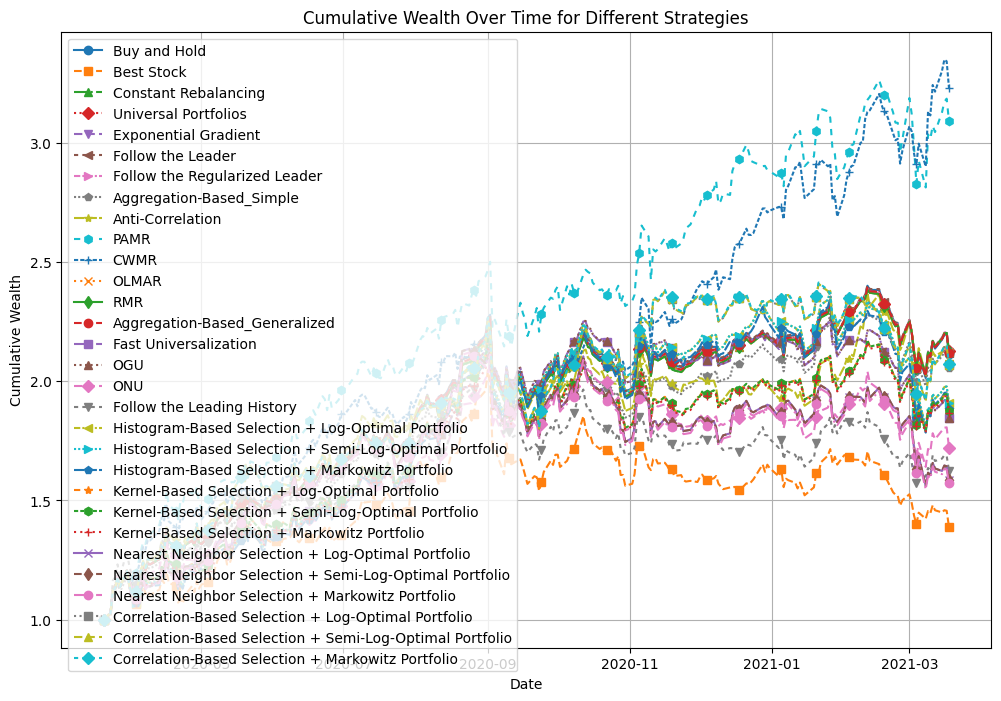

In [6]:
  # VISUALIZATION
import matplotlib.pyplot as plt
strategies = {
    'Buy and Hold': buy_and_hold,
    'Best Stock': best_stock,
    'Constant Rebalancing': constant_rebalancing,
    'Universal Portfolios': universal_portfolios,
    'Exponential Gradient': exponential_gradient,
    'Follow the Leader': follow_the_leader,
    'Follow the Regularized Leader': follow_the_regularized_leader,
    'Aggregation-Based_Simple': aggregation_based_simple,
    'Anti-Correlation': anticor,
    'PAMR': pamr,
    'CWMR': cwmr,
    'OLMAR': olmar,
    'RMR': rmr,
    "Aggregation-Based_Generalized" : aggregation_algorithm_generalized,
    "Fast Universalization" : fast_universalization,
    "OGU": online_gradient_update_meta,
    "ONU": online_newton_update_meta,
    "Follow the Leading History": follow_the_leading_history
    }

    # Pattern-Matching combos
sample_selection_methods = {
        'Histogram-Based Selection': histogram_based_selection,
        'Kernel-Based Selection': kernel_based_selection,
        'Nearest Neighbor Selection': nearest_neighbor_selection,
        'Correlation-Based Selection': correlation_based_selection
    }
portfolio_optimization_methods = {
        'Log-Optimal Portfolio': log_optimal_portfolio,
        'Semi-Log-Optimal Portfolio': semi_log_optimal_portfolio,
        'Markowitz Portfolio': markowitz_portfolio
    }
combos = []
for ss_name, ss_func in sample_selection_methods.items():
    for po_name, po_func in portfolio_optimization_methods.items():
        combination_name = f"{ss_name} + {po_name}"
        combos.append((combination_name, ss_func, po_func))

    # Add pattern-matching combos
for combination_name, ss_func, po_func in combos:
    def make_pattern_matching_strategy(ss=ss_func, po=po_func):
        def strategy(b, price_rels):
            methods = {'sample_selection': ss, 'portfolio_optimization': po}
            return pattern_matching_portfolio_master(b, price_rels, methods)
        return strategy
    strategies[combination_name] = make_pattern_matching_strategy()

cumulative_wealth_dict = {}
line_styles = ['-', '--', '-.', ':',
                   (0,(4,2)), (0,(2,2)), (0,(3,1,1,1)), (0,(1,1)),
                   (0,(5,1)), (0,(3,3)), (0,(2,1)), (0,(1,2,1,2))]
markers = ['o','s','^','D','v','<','>','p','*','h','+','x','d']

num_strategies = len(strategies)
if len(line_styles) < num_strategies:
    line_styles *= (num_strategies//len(line_styles)+1)
if len(markers) < num_strategies:
    markers *= (num_strategies//len(markers)+1)

plt.figure(figsize=(12,8))

for i, (strategy_name, strategy_function) in enumerate(strategies.items()):
    try:
        print(f"Running strategy: {strategy_name}")
        b_n_strat = strategy_function(b, price_relative_vectors_array)
        cum_wealth = calculate_cumulative_wealth_over_time(b_n_strat, price_relative_vectors_array)
        cumulative_wealth_dict[strategy_name] = cum_wealth
    except Exception as e:
        print(f"Error in {strategy_name}: {e}")
        continue

for i, (strategy_name, cum_wealth) in enumerate(cumulative_wealth_dict.items()):
    plt.plot(
        dates, cum_wealth,
        label=strategy_name,
        linestyle=line_styles[i],
        marker=markers[i],
        markevery=10,
        markersize=6,
        linewidth=1.5
    )

plt.title('Cumulative Wealth Over Time for Different Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth')
plt.legend()
plt.grid(True)
plt.show()